## Vanilla SVM Loss

Built with reference to http://cs231n.github.io/assignments2017/assignment1/ 

- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

### Import Function

In [2]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.debugger import set_trace

In [4]:
import time

### Data Preprocessing

In [5]:
PATH = 'data/cifar10'
X_train, y_train, X_test, y_test = load_CIFAR10(f'{PATH}')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

In [6]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape)

(49000, 32, 32, 3) (49000,) (1000, 32, 32, 3) (1000,) (500, 32, 32, 3) (500,) (1000, 32, 32, 3) (1000,)


In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3072) (1000, 3072) (1000, 3072) (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


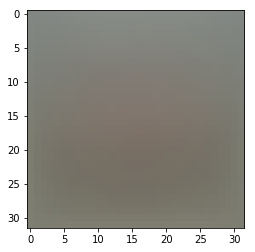

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


### SVM Naive Loss

In [15]:
W = np.random.randn(3073, 10) * 0.0001
print(W.shape)

(3073, 10)


In [26]:
def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength
    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero

  # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        diff_count = 0
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:
                diff_count += 1
                loss += margin
                # Gradient update for rows corresponds to the incorrect class
                dW[:, j] += X[i]
        # Gradient update rows corresponds to the correct class
        dW[:, y[i]] += -diff_count * X[i]

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
    loss /= num_train
    dW /= num_train

  # Add regularization to the loss.
    loss += 0.5 * reg * np.sum(W * W)
    dW += reg*W
    
    return loss, dW

from http://cs231n.github.io/optimization-1/
![SVM](image/SVM.png)

In [23]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    num_train = X.shape[0]
    delta = 1.0
    
    # evaluate class scores
    scores = X.dot(W)
    correct_class_score = scores[np.arange(num_train), y]
    margins = np.maximum(0, scores - np.expand_dims(correct_class_score, 1) + delta)
    margins[np.arange(num_train), y] = 0
    
    # Comp
    loss = np.sum(margins)
    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
    
    dx = np.zeros(margins.shape)
    dx[margins > 0] = 1
    num_pos = np.sum(dx, axis=1)
    dx[np.arange(num_train), y] = -num_pos
    
    dW = X.T.dot(dx)
    
    dW /= num_train
    dW += reg*W

    return loss, dW

In [27]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized)) 

Naive loss: 8.692604e+00 computed in 0.086515s
Vectorized loss: 8.692604e+00 computed in 0.007527s
difference: 0.000000


In [29]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference) 

Naive loss and gradient: computed in 0.084936s
Vectorized loss and gradient: computed in 0.007443s
difference: 0.000000


### Stochastic Gradient Descent

In [106]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
          # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None
            
            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            
            sample_indices = np.random.choice(np.arange(num_train), batch_size)
            
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################
            X_batch = X[sample_indices]
            y_batch = y[sample_indices]

          # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)
            
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            
            self.W += -learning_rate * grad
            
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################
            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: D x N array of training data. Each column is a D-dimensional point.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[1])

        y_pred = np.argmax(X.dot(self.W), axis=1)

        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative. 
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)


In [109]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 777.812714
iteration 100 / 1500: loss 283.440780
iteration 200 / 1500: loss 107.143580
iteration 300 / 1500: loss 42.166446
iteration 400 / 1500: loss 18.659098
iteration 500 / 1500: loss 10.321332
iteration 600 / 1500: loss 7.141670
iteration 700 / 1500: loss 5.744095
iteration 800 / 1500: loss 5.269255
iteration 900 / 1500: loss 5.201265
iteration 1000 / 1500: loss 5.644797
iteration 1100 / 1500: loss 5.008502
iteration 1200 / 1500: loss 5.439898
iteration 1300 / 1500: loss 4.810589
iteration 1400 / 1500: loss 5.589985
That took 8.689837s


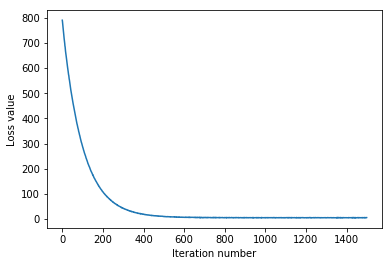

In [102]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [110]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370327
validation accuracy: 0.388000


In [111]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-8, 1e-7, 2e-7]
regularization_strengths = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 1e5]
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

for l in learning_rates:
    for r in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=l, reg=r, num_iters=1500, batch_size=200)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(l, r)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.220612 val accuracy: 0.214000
lr 1.000000e-08 reg 2.000000e+04 train accuracy: 0.221776 val accuracy: 0.230000
lr 1.000000e-08 reg 3.000000e+04 train accuracy: 0.226653 val accuracy: 0.231000
lr 1.000000e-08 reg 4.000000e+04 train accuracy: 0.250878 val accuracy: 0.253000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.244673 val accuracy: 0.261000
lr 1.000000e-08 reg 6.000000e+04 train accuracy: 0.264980 val accuracy: 0.276000
lr 1.000000e-08 reg 7.000000e+04 train accuracy: 0.280000 val accuracy: 0.289000
lr 1.000000e-08 reg 8.000000e+04 train accuracy: 0.280224 val accuracy: 0.282000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.296816 val accuracy: 0.311000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.372163 val accuracy: 0.377000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.381122 val accuracy: 0.374000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.382286 val accuracy: 0.398000
lr 1.000000e-07 reg 4.000000

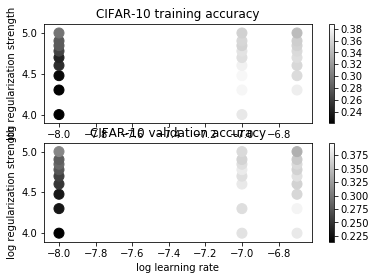

In [112]:

# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [113]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.375000


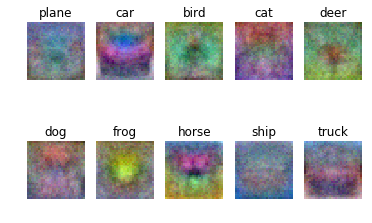

In [114]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])